In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import tensorflow.contrib.slim as slim  
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from gumbel import *
from ops import *
import reader
from tensorflow.python.client import device_lib

In [2]:
class Config(object):
    init_scale = 0.1
    max_epoch = 20
    max_max_epoch = 50
    batch_size = 20
    display_step = 100
    lr = 20.0
    lr_decay = 0.5
    embed_drop = 0.5
    input_drop = 0.5
    max_grad_norm = 0.25
    vocab_size = 10000
    tau0=5.0 # initial temperature
    ANNEAL_RATE=0.1
    MIN_TEMP=0.1
    beta = 0.01
    obj = 'ER' # 'MLE','VB','ER'
    
    # Network Parameters
    input_size = 300
    hidden_size = 450
    num_steps = 70 # timesteps
    num_layers = 1
    K= 8

In [3]:
class PTBInput(object):
    """The input data."""
    def __init__(self, config, data, name=None):
        self.batch_size = config.batch_size
        self.num_steps = config.num_steps
        self.epoch_size = ((len(data) // self.batch_size) - 1) // self.num_steps
        self.input_data, self.targets = reader.ptb_producer(data, self.batch_size, self.num_steps, name=name)

def PrintPTBSentence(data, dict):
    n, timestep = data.shape
    s = []
    for i in range(n):
        temp = []
        for j in range(timestep):
            temp.append(dict[data[i][j]])
        s.append(temp)
    s = np.array(s)
    
    return s

def Dropoutcell(config, is_training):
    cell = tf.contrib.rnn.BasicLSTMCell(config.hidden_size, forget_bias=0.0,state_is_tuple=True)
    if is_training:
        cell = tf.contrib.rnn.DropoutWrapper(cell,
                                             output_keep_prob=config.keep_prob,
                                             variational_recurrent=False,
                                             dtype=tf.float32)
    return cell

def run_epoch(session, model, eval_op=None, verbose=False):
    """Runs the model on the given data."""
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = session.run(model.initial_state)

    fetches = {
        "NLL": model.NLL,
        "final_state": model.final_state,
        "entropy": model.entropy
    }
    if eval_op is not None:
        fetches["eval_op"] = eval_op

    for step in range(model.data.epoch_size):
        feed_dict = {}
        feed_dict[model.initial_state] = state
        
        vals = session.run(fetches, feed_dict)
        cost = vals["NLL"]
        state = vals["final_state"]
        entropy = vals["entropy"]

        costs += cost
        iters += model.data.num_steps

        if verbose and step % (model.data.epoch_size // 10) == 10:
            print("%.3f perplexity: %.3f speed: %.0f wps NLL: %.3f entropy: %f" %
                  (step * 1.0 / model.data.epoch_size, np.exp(costs / iters),\
                   iters * model.data.batch_size /(time.time() - start_time),\
                   cost,entropy))

    return np.exp(costs / iters)

In [4]:
class PTBModel(object):
    def __init__(self, is_training, config, data):
        training = tf.placeholder(tf.bool)
        self.data = data
        self.batch_size = data.batch_size
        self.num_steps = data.num_steps
        self.tau = tf.Variable(0.0, trainable=False)
        self.lr  = tf.Variable(0.0, trainable=False)
        
        with tf.device("/cpu:0"):
            self.embedding = tf.get_variable("embedding", [config.vocab_size, config.input_size], dtype=tf.float32)
            self.inputs = tf.nn.embedding_lookup(self.embedding, self.data.input_data)
        if is_training and config.embed_drop < 1:
            self.inputs = tf.nn.dropout(self.inputs, config.embed_drop)
        with tf.variable_scope("model", reuse=tf.AUTO_REUSE ):
            
            self.initial_state = tf.zeros([config.num_layers,self.batch_size,config.hidden_size*2])
            
            self.state = self.initial_state
            self.outputs = []
            self.ALL_z = []
            self.ALL_qz = []
            self.ALL_h = []
            self.ALL_state = []
        with tf.variable_scope("MRNN", reuse=tf.AUTO_REUSE):
            cur_output = tf.unstack(self.inputs, self.num_steps, 1)
            for layer in range(config.num_layers):
                state_output = []
                h_output = []
                cur_input = cur_output
                cur_state = self.state[layer]
                with tf.variable_scope("layer"+str(layer+1), reuse=tf.AUTO_REUSE):
                    for time_step in range(self.num_steps):
                        old_h, old_c = tf.split(value=cur_state, num_or_size_splits=2, axis=1)
                        with tf.variable_scope('logit_enc'):
                            logit_z = linear(tf.concat([cur_input[time_step],old_h],1), config.K, name='h_zin')
                        q_z = tf.nn.softmax(logit_z)
                        if is_training is True:
                            z = gumbel_softmax(logit_z,self.tau,hard=False)
                        else:
                            z = softmax_sample(logit_z)
                        self.ALL_z.append(z)
                        self.ALL_qz.append(q_z)

                        gates = linear(tf.concat([cur_input[time_step], old_h], 1),\
                                       config.hidden_size*config.K*4, name='gate')
                        i, g, f, o = tf.split(value=gates, num_or_size_splits=4, axis=1)
                        old_c_K = tf.tile(old_c,[1,config.K])
                        new_c_K = tf.multiply(tf.sigmoid(f), old_c_K) + tf.multiply(tf.sigmoid(i), tf.tanh(g))
                        new_h_K = tf.multiply(tf.sigmoid(o), tf.tanh(new_c_K))
                        new_c_K = tf.reshape(new_c_K, [self.batch_size,config.K,config.hidden_size])
                        new_h_K = tf.reshape(new_h_K, [self.batch_size,config.K,config.hidden_size])
                        new_h = tf.einsum('nkd,nk->nd',new_h_K,z)
                        new_c = tf.einsum('nkd,nk->nd',new_c_K,z)

                        if is_training and config.input_drop < 1:
                            new_h = tf.nn.dropout(new_h, config.input_drop)

                        cur_state = tf.concat([new_h, new_c], 1)
                        state_output.append(cur_state)
                        h_output.append(new_h)
                cur_output = h_output
                self.ALL_h.append(h_output)
                self.ALL_state.append(state_output)
        self.state = tf.convert_to_tensor(self.ALL_state)[:,-1,:,:]
        self.arrange_outputs = tf.reshape(tf.concat(cur_output, 1), [-1, config.hidden_size])
        self.logits = tf.reshape(linear(self.arrange_outputs, config.vocab_size),\
                                 [self.batch_size, self.num_steps, config.vocab_size])
        
        cross_entropy = tf.contrib.seq2seq.sequence_loss(
            self.logits,
            self.data.targets,
            tf.ones([self.batch_size, self.num_steps], dtype=tf.float32),
            average_across_timesteps=False,
            average_across_batch=True)
        self.NLL = tf.reduce_sum(cross_entropy)
        
        ALL_q_z_tmp = tf.transpose(self.ALL_qz,[1,0,2])
        entropy = -ALL_q_z_tmp*tf.log(ALL_q_z_tmp+1e-20)
        self.entropy = tf.reduce_mean(tf.reduce_sum(entropy,[1, 2]))
        
        if config.obj == 'ER':
            self.cost = self.NLL - config.beta*self.entropy
        elif config.obj == 'VB':
            self.cost = self.NLL - self.entropy
        elif config.obj == 'MLE':
            self.cost = self.NLL
    
        self.final_state = self.state
        
        if not is_training:
            return
    
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),config.max_grad_norm)
        optimizer = tf.train.GradientDescentOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(
            zip(grads, tvars),
            global_step=tf.contrib.framework.get_or_create_global_step())
    
        self.new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self.lr_update = tf.assign(self.lr, self.new_lr)
        self.new_tau = tf.placeholder(tf.float32, shape=[], name="new_tau")
        self.tau_update = tf.assign(self.tau, self.new_tau)
        
    def assign_lr(self, session, lr_value):
        session.run(self.lr_update, feed_dict={self.new_lr: lr_value})
    def assign_tau(self, session, tau_value):
        session.run(self.tau_update, feed_dict={self.new_tau: tau_value})

In [5]:
import os
raw_data = reader.ptb_raw_data('./data/')
train_data, valid_data, test_data, w2id, id2w = raw_data
config = Config()
eval_config = Config()
eval_config.batch_size = 1
eval_config.num_steps = 1

import os
if config.obj == 'ER':
    URL = './checkpoint/MRNN_L='+str(config.num_layers)+"_D="+str(config.hidden_size)+"_K="+str(config.K)+'_ER'+'_beta='+str(config.beta)
else:
    URL = './checkpoint/MRNN_L='+str(config.num_layers)+"_D="+str(config.hidden_size)+"_K="+str(config.K)+'_'+str(config.obj)
    
if not os.path.exists(URL):
    os.makedirs(URL)

In [6]:
initializer = tf.random_uniform_initializer(-config.init_scale,config.init_scale)

with tf.name_scope("Train"):
    train_input = PTBInput(config=config, data=train_data, name="TrainInput")
    with tf.variable_scope("Model", reuse=None, initializer=initializer):
        m = PTBModel(is_training=True, config=config, data=train_input)

with tf.name_scope("Valid"):
    valid_input = PTBInput(config=config, data=valid_data, name="ValidInput")
    with tf.variable_scope("Model", reuse=True, initializer=initializer):
        mvalid = PTBModel(is_training=False, config=config, data=valid_input)

with tf.name_scope("Test"):
    test_input = PTBInput(config=eval_config, data=test_data, name="TestInput")
    with tf.variable_scope("Model", reuse=True, initializer=initializer):
        mtest = PTBModel(is_training=False, config=config, data=test_input)

Instructions for updating:
Please switch to tf.train.get_or_create_global_step


In [7]:
# Launch the graph
sv = tf.train.Supervisor()
with sv.managed_session() as sess:
    
    ppl_train = []
    ppl_valid = [np.inf]
    m.assign_lr(sess, config.lr)
    start_time = time.time()
    for i in range(config.max_max_epoch):
        
        np_temp=np.maximum(config.tau0*np.exp(-config.ANNEAL_RATE*i),config.MIN_TEMP)
        m.assign_tau(sess, np_temp)
        temp_lr, temp_tau = sess.run([m.lr, m.tau])
        if temp_lr < 0.5:
            break
        
        print("Epoch: %d Learning rate: %f, Temperature: %f" % (i + 1, temp_lr, temp_tau))
        train_perplexity = run_epoch(sess, m, eval_op=m.train_op,verbose=True)
        ppl_train.append(train_perplexity)
        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        
        valid_perplexity = run_epoch(sess, mvalid)
        print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))
        ppl_valid.append(valid_perplexity)

        if (i+1) > config.max_epoch:
            if ppl_valid[-2] - ppl_valid[-1] < 0:
                m.assign_lr(sess, temp_lr * config.lr_decay)
                
#         if (i+1) > config.max_epoch:
#             m.assign_lr(sess, temp_lr * config.lr_decay)
    
    end_time = time.time()
    test_perplexity = run_epoch(sess, mtest)
    print("Test Perplexity: %.3f" % test_perplexity)
    print("Training time: %f, Testing time: %f" % (end_time-start_time,time.time()-end_time))
    
    sv.saver.save(sess, URL+"/model.ckpt")

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch: 1 Learning rate: 20.000000, Temperature: 5.000000
0.015 perplexity: 2422.651 speed: 5587 wps NLL: 510.158 entropy: 144.751785
0.115 perplexity: 1078.353 speed: 11281 wps NLL: 468.700 entropy: 145.015289
0.214 perplexity: 857.353 speed: 12252 wps NLL: 452.530 entropy: 144.948288
0.314 perplexity: 736.668 speed: 12651 wps NLL: 439.328 entropy: 144.898392
0.413 perplexity: 660.447 speed: 12864 wps NLL: 424.809 entropy: 144.810471
0.513 perplexity: 603.686 speed: 12995 wps NLL: 425.729 entropy: 144.771210
0.612 perplexity: 554.411 speed: 13090 wps NLL: 394.610 entropy: 144.668777
0.712 perplexity: 518.121 speed: 13157 wps NLL: 414.521 entropy: 144.730759
0.811 perplexity: 487.505 speed: 13207 wps NLL: 401.767 entropy: 144.596893
0.911 perplexity: 461.468 speed: 13245 wps NLL: 369.666 entropy: 144.561859
Epoch: 1 Train Perplexity: 443.032
Epoch: 1 Valid Perplexity: 275.155
Epoch: 2 Learning rate: 20.0

0.115 perplexity: 89.511 speed: 13546 wps NLL: 328.025 entropy: 81.921257
0.214 perplexity: 96.547 speed: 13547 wps NLL: 321.243 entropy: 84.272423
0.314 perplexity: 94.402 speed: 13546 wps NLL: 320.498 entropy: 81.350479
0.413 perplexity: 94.869 speed: 13549 wps NLL: 312.391 entropy: 79.236671
0.513 perplexity: 94.694 speed: 13564 wps NLL: 315.202 entropy: 78.181183
0.612 perplexity: 93.633 speed: 13556 wps NLL: 304.388 entropy: 76.708237
0.712 perplexity: 93.754 speed: 13553 wps NLL: 326.928 entropy: 79.787613
0.811 perplexity: 93.458 speed: 13554 wps NLL: 307.872 entropy: 77.490440
0.911 perplexity: 92.315 speed: 13552 wps NLL: 284.167 entropy: 69.748032
Epoch: 10 Train Perplexity: 92.248
Epoch: 10 Valid Perplexity: 109.242
Epoch: 11 Learning rate: 20.000000, Temperature: 1.839397
0.015 perplexity: 94.955 speed: 13660 wps NLL: 327.736 entropy: 78.041428
0.115 perplexity: 84.938 speed: 13581 wps NLL: 323.780 entropy: 78.558739
0.214 perplexity: 91.738 speed: 13568 wps NLL: 321.790 en

0.712 perplexity: 72.534 speed: 13581 wps NLL: 307.260 entropy: 29.703207
0.811 perplexity: 72.435 speed: 13578 wps NLL: 291.333 entropy: 28.523899
0.911 perplexity: 71.593 speed: 13581 wps NLL: 269.846 entropy: 26.439734
Epoch: 19 Train Perplexity: 71.650
Epoch: 19 Valid Perplexity: 92.409
Epoch: 20 Learning rate: 20.000000, Temperature: 0.747843
0.015 perplexity: 76.016 speed: 13507 wps NLL: 313.917 entropy: 28.041058
0.115 perplexity: 68.096 speed: 13555 wps NLL: 309.163 entropy: 27.764416
0.214 perplexity: 73.417 speed: 13566 wps NLL: 305.979 entropy: 28.566650
0.314 perplexity: 71.744 speed: 13574 wps NLL: 301.465 entropy: 25.492977
0.413 perplexity: 72.037 speed: 13587 wps NLL: 294.906 entropy: 25.700169
0.513 perplexity: 72.041 speed: 13591 wps NLL: 289.717 entropy: 23.579823
0.612 perplexity: 71.393 speed: 13576 wps NLL: 287.123 entropy: 23.845892
0.712 perplexity: 71.714 speed: 13575 wps NLL: 309.636 entropy: 24.908178
0.811 perplexity: 71.602 speed: 13580 wps NLL: 289.329 ent

0.115 perplexity: 60.315 speed: 13591 wps NLL: 297.920 entropy: 9.406151
0.214 perplexity: 64.204 speed: 13574 wps NLL: 293.212 entropy: 9.457312
0.314 perplexity: 62.599 speed: 13558 wps NLL: 293.846 entropy: 9.644365
0.413 perplexity: 62.611 speed: 13556 wps NLL: 285.074 entropy: 9.471361
0.513 perplexity: 62.592 speed: 13553 wps NLL: 287.316 entropy: 9.396225
0.612 perplexity: 61.904 speed: 13558 wps NLL: 275.156 entropy: 8.694921
0.712 perplexity: 61.900 speed: 13559 wps NLL: 299.194 entropy: 9.770745
0.811 perplexity: 61.605 speed: 13560 wps NLL: 279.248 entropy: 9.974934
0.911 perplexity: 60.665 speed: 13556 wps NLL: 254.877 entropy: 8.033951
Epoch: 29 Train Perplexity: 60.578
Epoch: 29 Valid Perplexity: 87.262
Epoch: 30 Learning rate: 5.000000, Temperature: 0.275116
0.015 perplexity: 65.028 speed: 13669 wps NLL: 305.804 entropy: 9.410776
0.115 perplexity: 58.589 speed: 13543 wps NLL: 297.196 entropy: 9.535162
0.214 perplexity: 62.583 speed: 13541 wps NLL: 294.031 entropy: 9.7541

0.811 perplexity: 57.308 speed: 13578 wps NLL: 276.473 entropy: 8.034269
0.911 perplexity: 56.538 speed: 13578 wps NLL: 249.618 entropy: 7.572295
Epoch: 38 Train Perplexity: 56.493
Epoch: 38 Valid Perplexity: 85.787
Epoch: 39 Learning rate: 2.500000, Temperature: 0.111854
0.015 perplexity: 61.410 speed: 13678 wps NLL: 297.428 entropy: 7.372790
0.115 perplexity: 55.425 speed: 13607 wps NLL: 294.693 entropy: 8.729998
0.214 perplexity: 59.030 speed: 13602 wps NLL: 291.861 entropy: 8.389399
0.314 perplexity: 57.498 speed: 13584 wps NLL: 283.908 entropy: 8.171863
0.413 perplexity: 57.745 speed: 13575 wps NLL: 281.935 entropy: 7.917727
0.513 perplexity: 57.829 speed: 13567 wps NLL: 280.871 entropy: 7.670374
0.612 perplexity: 57.229 speed: 13572 wps NLL: 266.882 entropy: 7.515131
0.712 perplexity: 57.399 speed: 13576 wps NLL: 296.487 entropy: 7.206529
0.811 perplexity: 57.189 speed: 13575 wps NLL: 275.110 entropy: 8.231474
0.911 perplexity: 56.406 speed: 13574 wps NLL: 247.899 entropy: 7.7112

0.314 perplexity: 55.678 speed: 13613 wps NLL: 282.701 entropy: 7.667289
0.413 perplexity: 55.876 speed: 13603 wps NLL: 278.823 entropy: 7.785729
0.513 perplexity: 55.890 speed: 13594 wps NLL: 279.853 entropy: 7.528533
0.612 perplexity: 55.293 speed: 13587 wps NLL: 261.544 entropy: 7.381372
0.712 perplexity: 55.413 speed: 13584 wps NLL: 289.755 entropy: 7.400358
0.811 perplexity: 55.250 speed: 13582 wps NLL: 272.922 entropy: 7.461352
0.911 perplexity: 54.480 speed: 13582 wps NLL: 249.414 entropy: 6.596066
Epoch: 48 Train Perplexity: 54.421
Epoch: 48 Valid Perplexity: 85.126
Epoch: 49 Learning rate: 0.625000, Temperature: 0.100000
0.015 perplexity: 59.484 speed: 13574 wps NLL: 294.651 entropy: 7.018222
0.115 perplexity: 53.413 speed: 13597 wps NLL: 291.084 entropy: 7.559186
0.214 perplexity: 56.781 speed: 13555 wps NLL: 286.929 entropy: 7.436254
0.314 perplexity: 55.395 speed: 13557 wps NLL: 284.841 entropy: 7.436677
0.413 perplexity: 55.682 speed: 13564 wps NLL: 279.208 entropy: 7.7088

In [8]:
total_para = 0
for var in tf.trainable_variables():
    shape = var.get_shape()
    tmp = 1
    for dim in shape:
        tmp *= dim.value
    total_para += tmp
print('Total parameters: ', total_para)
print(tf.trainable_variables())

Total parameters:  18330408
[<tf.Variable 'Model/embedding:0' shape=(10000, 300) dtype=float32_ref>, <tf.Variable 'Model/MRNN/layer1/logit_enc/h_zin/weights:0' shape=(750, 8) dtype=float32_ref>, <tf.Variable 'Model/MRNN/layer1/logit_enc/h_zin/biases:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'Model/MRNN/layer1/gate/weights:0' shape=(750, 14400) dtype=float32_ref>, <tf.Variable 'Model/MRNN/layer1/gate/biases:0' shape=(14400,) dtype=float32_ref>, <tf.Variable 'Model/linear/weights:0' shape=(450, 10000) dtype=float32_ref>, <tf.Variable 'Model/linear/biases:0' shape=(10000,) dtype=float32_ref>]


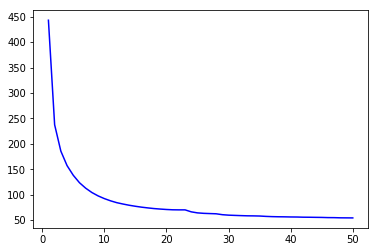

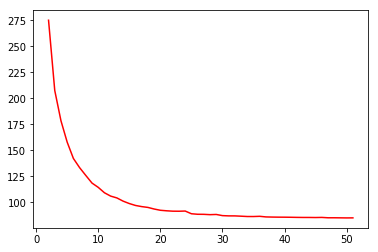

In [9]:
# Plot learning curve
plt.figure()
plt.plot(range(1,len(ppl_train)+1),ppl_train,'b')
plt.show()
plt.figure()
plt.plot(range(1,len(ppl_valid)+1),ppl_valid,'r')
plt.show()

In [10]:
np.savetxt("temp1.csv", ppl_train, delimiter=",")
np.savetxt("temp2.csv", ppl_valid, delimiter=",")

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=3)

model = mtest
sv = tf.train.Supervisor()
z = []
qz = []
h = []
x = []
y = []
logits = []
start_time = time.time()
with sv.managed_session() as sess:
    sv.saver.restore(sess, URL+"/model.ckpt")

    state = sess.run(model.initial_state)
    fetches = {
        "z": model.ALL_z,
        "qz": model.ALL_qz,
        "h": model.state,
        "x": model.data.input_data,
        "y": model.data.targets,
        "logits":model.logits,
        "final_state": model.final_state,
    }
    print(model.data.epoch_size)
    for i in range(model.data.epoch_size):
        feed_dict = {}
        feed_dict[model.initial_state] = state
        vals = sess.run(fetches, feed_dict)
        state = vals["final_state"]
        
        
        h.append(vals['h'])
        qz.append(vals['qz'])
        z.append(vals['z'])
        x.append(vals['x'])
        y.append(vals['y'])
        logits.append(vals['logits'])
        
        
#         print(id2w[vals['x'][0][0]])
#         print(id2w[vals['y'][0][0]])
#         print(id2w[np.argmax(vals['logits'])])
#         print('-----------------')
    end_time = time.time()
    print("time: %f" % (end_time-start_time))

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Restoring parameters from ./checkpoint/MRNN_L=1_D=450_K=8_ER_beta=0.01/model.ckpt
82429
time: 177.225399


In [12]:
h = np.array(h)
print(h.shape)
h = np.array(np.split(h,2,3))
print(h.shape)
z = np.squeeze(np.array(z),[1,2])
print(z.shape)
qz = np.squeeze(np.array(qz),[1,2])
print(qz.shape)
x = np.array(x)
print(x.shape)
y = np.array(y)
print(y.shape)
logits = np.squeeze(np.array(logits),[1,2])
print(logits.shape)

(82429, 1, 1, 900)
(2, 82429, 1, 1, 450)
(82429, 8)
(82429, 8)
(82429, 1, 1)
(82429, 1, 1)
(82429, 10000)


In [14]:
from sklearn.manifold import TSNE
start_time = time.time()
N = 10000
# h_tsne = TSNE(n_components=2).fit_transform(h[:N,1,:])
h_tsne = TSNE(n_components=2).fit_transform(h[0,:N,0,0,:])
print("time: %f" % (time.time()-start_time))

time: 271.611849


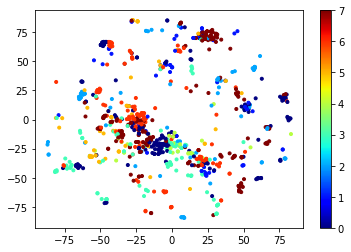

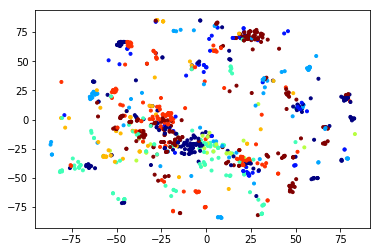

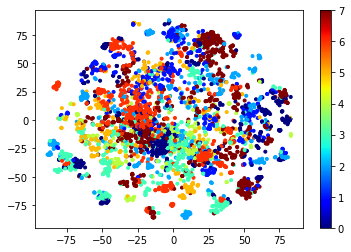

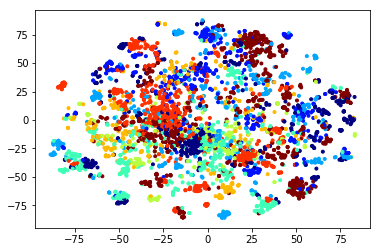

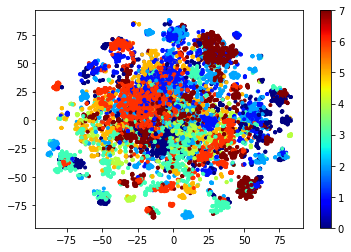

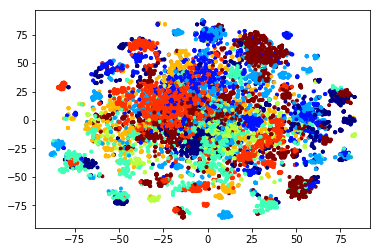

In [15]:
fig = plt.figure()
# color = ['r','g','b','y']
for i in [1000,5000,10000]:
    plt.scatter(h_tsne[:i,0], h_tsne[:i,1], c=np.argmax(z,1)[:i], marker='.', cmap = plt.cm.jet)
    plt.colorbar()
    plt.savefig(URL+'/tsne_'+str(i)+'.png')
    plt.show()
    plt.scatter(h_tsne[:i,0], h_tsne[:i,1], c=np.argmax(z,1)[:i], marker='.', cmap = plt.cm.jet)
    plt.savefig(URL+'/tsne_'+str(i)+'_nobar.png')
    plt.show()

In [16]:
import scipy.io as sio
sio.savemat(URL+'/tsne.mat', {'h_tsne': h_tsne, 'z': z[:N]})

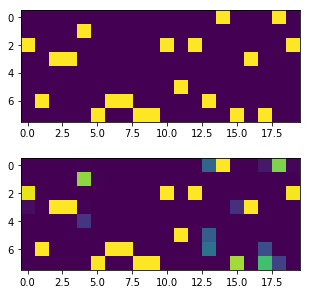

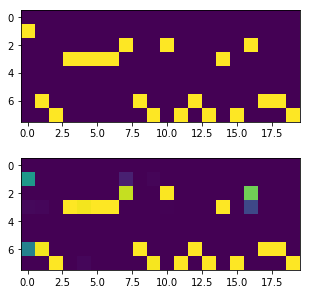

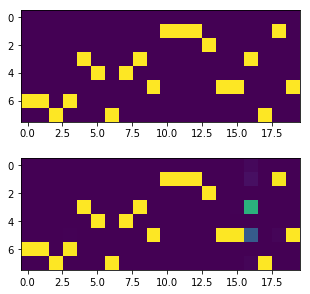

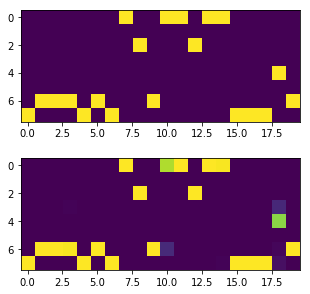

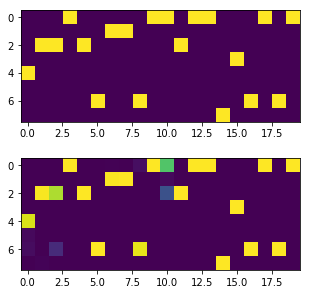

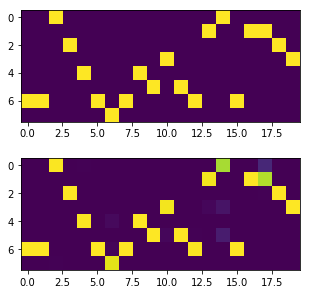

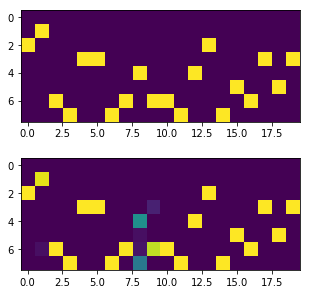

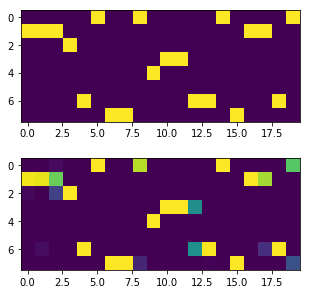

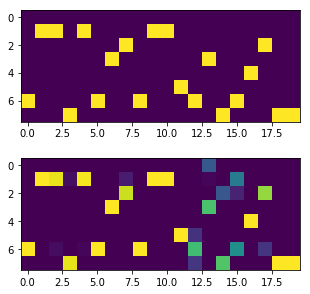

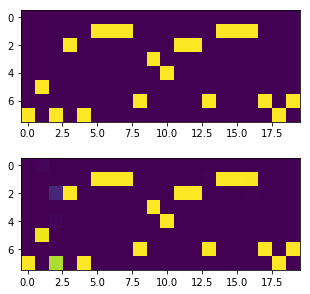

In [17]:
N1 = 0
N2 = 20
step=1000
N=10000
for i in range(0,N,step):
    fig = plt.figure(figsize=[5,5])
    plt.subplot(2,1,1)
    plt.imshow(z[N1+i:N2+i,:].T)
    plt.subplot(2,1,2)
    plt.imshow(qz[N1+i:N2+i,:].T)
    plt.savefig(URL+'/traj_'+str(i)+'.png')
    plt.show()

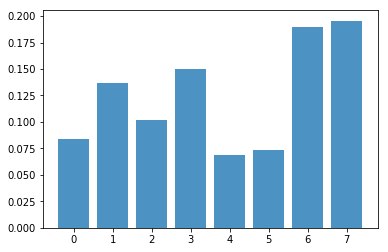

In [18]:
plt.bar(np.arange(config.K), np.sum(z,0)/np.sum(z), alpha=0.8)
plt.savefig(URL+'/stat.png')
plt.show()

In [19]:
for i in range(0,20):
    print(id2w[x[0+i,0,0]], end=" ")

no it was n't black monday <eos> but while the new york stock exchange did n't fall apart friday as 